In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
from tqdm.auto import tqdm
import pandas as pd
import networkx as nx

In [3]:
project_root = os.path.abspath(
    os.path.join("C:/Users/jllgo/OneDrive/Documentos/UFMG/MSc & MSI 2/MatchSegmentation")
)
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.pass_networks.process_intervals import load_graphs
from src.pass_networks.pass_network import calculate_metrics 
from src.pass_networks.custom_metrics import calculate_average_path_legth_target
from src.pass_networks.custom_metrics import calculate_ffl
from src.pass_networks.custom_metrics import calculate_simrank
from src.pass_networks.custom_metrics import calculate_wasserstein_distance
from src.pass_networks.custom_metrics import calculate_modularity
from src.pass_networks.custom_metrics import calculate_graph_distance_stream

# Get Graphs

In [5]:
PROCESSED_DATA_PATH = "../data/processed/PL-22-23"
CSV_DATA_PATH = "../data/csv"

In [6]:
games = os.listdir(PROCESSED_DATA_PATH)
game_ids = [game.split('.')[0] for game in games]
print(f"Games to process: {len(game_ids)}")

Games to process: 9


In [7]:
matches = []

for match_id in tqdm(game_ids, desc="Loading Graphs", total=len(game_ids)):
    match_graphs = load_graphs(match_id, PROCESSED_DATA_PATH)
    matches += match_graphs

Loading Graphs:   0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
matches_df = pd.DataFrame(matches)
matches_df

,match_id,interval_id,team_id,graph
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
1,4436,1.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)"
2,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
3,4436,2.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)"
4,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
...,...,...,...,...
877,4446,49.0,9,"(-1, 1, 6, 2, 25, 26, 10, 14, 27, 3, 20, 22)"
878,4446,50.0,2,"(-1, 3, 34, 11, 14, 1, 5, 8, 6, 12, 18, 10)"
879,4446,50.0,9,"(-1, 1, 6, 2, 25, 26, 10, 14, 27, 3, 20, 22)"
880,4446,51.0,2,"(-1, 3, 34, 11, 14, 1, 5, 8, 6, 12, 18, 10)"


# Graph Stream

In [9]:
selected_metrics = {
    "Density": nx.density,
    "Average Clustering": nx.average_clustering,
    "Betweenness Centrality": nx.betweenness_centrality,
    "Closeness Centrality": nx.closeness_centrality,
    "Averge Path Length": calculate_average_path_legth_target,
}

In [10]:
distance_metrics = {    
    "Wasserstein": calculate_wasserstein_distance
}

In [11]:
for metric_name, metric_func in selected_metrics.items():
    matches_df[metric_name] = matches_df["graph"].apply(lambda x: metric_func(x))

matches_df.head()

,match_id,interval_id,team_id,graph,Density,Average Clustering,Betweenness Centrality,Closeness Centrality,Averge Path Length
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.106061,0.000000,"{-1: 0.0, 35: 0.14545454545454545, 9: 0.0, 34:...","{-1: 0.0, 35: 0.3232323232323232, 9: 0.1888111...",inf
1,4436,1.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)",0.090909,0.089286,"{-1: 0.0, 17: 0.09090909090909091, 13: 0.0, 15...","{-1: 0.0, 17: 0.25252525252525254, 13: 0.0, 15...",inf
2,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.075758,0.062500,"{-1: 0.0, 35: 0.09999999999999999, 9: 0.009090...","{-1: 0.2727272727272727, 35: 0.204545454545454...",1.714286
3,4436,2.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)",0.090909,0.126389,"{-1: 0.0, 17: 0.0, 13: 0.03636363636363636, 15...","{-1: 0.0, 17: 0.1818181818181818, 13: 0.192513...",inf
4,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.174242,0.242645,"{-1: 0.0, 35: 0.10454545454545452, 9: 0.081818...","{-1: 0.0, 35: 0.43315508021390375, 9: 0.409090...",inf


In [12]:
df_sorted = matches_df.sort_values(by=['match_id', 'team_id', 'interval_id']).reset_index(drop=True)
df_sorted

,match_id,interval_id,team_id,graph,Density,Average Clustering,Betweenness Centrality,Closeness Centrality,Averge Path Length
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.106061,0.000000,"{-1: 0.0, 35: 0.14545454545454545, 9: 0.0, 34:...","{-1: 0.0, 35: 0.3232323232323232, 9: 0.1888111...",inf
1,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.075758,0.062500,"{-1: 0.0, 35: 0.09999999999999999, 9: 0.009090...","{-1: 0.2727272727272727, 35: 0.204545454545454...",1.714286
2,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.174242,0.242645,"{-1: 0.0, 35: 0.10454545454545452, 9: 0.081818...","{-1: 0.0, 35: 0.43315508021390375, 9: 0.409090...",inf
3,4436,4.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.090909,0.058532,"{-1: 0.0, 35: 0.39999999999999997, 9: 0.127272...","{-1: 0.28321678321678323, 35: 0.34224598930481...",2.600000
4,4436,5.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.121212,0.129299,"{-1: 0.0, 35: 0.13636363636363635, 9: 0.099999...","{-1: 0.27548209366391185, 35: 0.33471074380165...",3.000000
...,...,...,...,...,...,...,...,...,...
877,4446,47.0,9,"(-1, 1, 6, 2, 25, 26, 10, 14, 27, 3, 20, 22)",0.000000,0.000000,"{-1: 0.0, 1: 0.0, 6: 0.0, 2: 0.0, 25: 0.0, 26:...","{-1: 0.0, 1: 0.0, 6: 0.0, 2: 0.0, 25: 0.0, 26:...",inf
878,4446,48.0,9,"(-1, 1, 6, 2, 25, 26, 10, 14, 27, 3, 20, 22)",0.000000,0.000000,"{-1: 0.0, 1: 0.0, 6: 0.0, 2: 0.0, 25: 0.0, 26:...","{-1: 0.0, 1: 0.0, 6: 0.0, 2: 0.0, 25: 0.0, 26:...",inf
879,4446,49.0,9,"(-1, 1, 6, 2, 25, 26, 10, 14, 27, 3, 20, 22)",0.000000,0.000000,"{-1: 0.0, 1: 0.0, 6: 0.0, 2: 0.0, 25: 0.0, 26:...","{-1: 0.0, 1: 0.0, 6: 0.0, 2: 0.0, 25: 0.0, 26:...",inf
880,4446,50.0,9,"(-1, 1, 6, 2, 25, 26, 10, 14, 27, 3, 20, 22)",0.000000,0.000000,"{-1: 0.0, 1: 0.0, 6: 0.0, 2: 0.0, 25: 0.0, 26:...","{-1: 0.0, 1: 0.0, 6: 0.0, 2: 0.0, 25: 0.0, 26:...",inf


In [13]:
# Lista para armazenar os resultados
distance_data = []

# Itera sobre os grupos de 'match_id' e 'team_id'
for (match_id, team_id), group in tqdm(df_sorted.groupby(['match_id', 'team_id']), desc="Calculating Distances", total=len(df_sorted.groupby(['match_id', 'team_id']))):
    # Ordena o grupo por 'interval_id'
    group = group.sort_values(by='interval_id').reset_index(drop=True)
    # Itera sobre os pares de grafos consecutivos
    for i in tqdm(range(len(group) - 1), desc="Calculating Distances", total=len(group) - 1):
        current_row = group.iloc[i]
        next_row = group.iloc[i + 1]
        # Verifica se os 'interval_id' são consecutivos
        distances = {'match_id': match_id, 'team_id': team_id, 'interval_id': current_row['interval_id']}
        G1 = current_row['graph']
        G2 = next_row['graph']
        # Calcula cada métrica de distância
        for metric_name, metric_fn in distance_metrics.items():
            distances[metric_name] = metric_fn(G1, G2)
        distance_data.append(distances)

# Cria o novo DataFrame com as métricas de distância
df_distances = pd.DataFrame(distance_data)
df_distances

Calculating Distances:   0%|          | 0/18 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/47 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/47 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/49 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/49 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/48 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/48 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/47 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/47 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/47 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/47 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/47 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/47 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/51 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/51 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/48 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/48 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/48 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/48 [00:00<?, ?it/s]

,match_id,team_id,interval_id,Wasserstein
0,4436,2,1.0,0.666667
1,4436,2,2.0,2.166667
2,4436,2,3.0,1.833333
3,4436,2,4.0,0.666667
4,4436,2,5.0,0.666667
...,...,...,...,...
859,4446,9,46.0,0.000000
860,4446,9,47.0,0.000000
861,4446,9,48.0,0.000000
862,4446,9,49.0,0.000000


# Concept Drift

In [14]:
import numpy as np

In [33]:
drift_stream_df = df_distances.groupby(['match_id', 'interval_id']).agg(
    diff=('Wasserstein', 'sum'),
).reset_index()
drift_stream_df

,match_id,interval_id,diff
0,4436,1.0,1.000000
1,4436,2.0,3.833333
2,4436,3.0,2.166667
3,4436,4.0,1.166667
4,4436,5.0,1.333333
...,...,...,...
427,4446,46.0,0.000000
428,4446,47.0,0.000000
429,4446,48.0,0.000000
430,4446,49.0,0.000000


In [31]:
from src.concept_drift.drift_points import detect_kswin_drift
import numpy as np

In [36]:
drift_points = []
for match_id in tqdm(drift_stream_df['match_id'].unique(), desc="Drift Analysis", total=len(drift_stream_df['match_id'].unique())):
    match_df = drift_stream_df[drift_stream_df['match_id'] == match_id].reset_index(drop=True)

    drift_sum = match_df['diff'].tolist()
    sum_drift_points = detect_kswin_drift(drift_sum, a=0.1,ws=10,ss=3,seed=42)

    drift_points.append({
        'match_id': int(match_id),
        'sum_drift_points': sum_drift_points,
    })
    
drift_points

Drift Analysis:   0%|          | 0/9 [00:00<?, ?it/s]

[{'match_id': 4436, 'sum_drift_points': [9, 21, 39]},
 {'match_id': 4438, 'sum_drift_points': [17, 39]},
 {'match_id': 4439, 'sum_drift_points': [13]},
 {'match_id': 4440, 'sum_drift_points': [9, 23, 40]},
 {'match_id': 4441, 'sum_drift_points': [10, 22]},
 {'match_id': 4442, 'sum_drift_points': [20, 35]},
 {'match_id': 4443, 'sum_drift_points': [16, 27, 43]},
 {'match_id': 4444, 'sum_drift_points': [9, 25, 36]},
 {'match_id': 4446, 'sum_drift_points': []}]

# Viz

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_match_segmentation(match_id, metric_series, drift_points):
    plt.figure(figsize=(20, 5))
    plt.plot(metric_series)
    for point in drift_points:
        plt.axvline(x=point, color='r', linestyle='--')

    plt.xticks(np.arange(0, len(metric_series), step=2))
    plt.title(f"Match {match_id} Segmentation")
    plt.show()

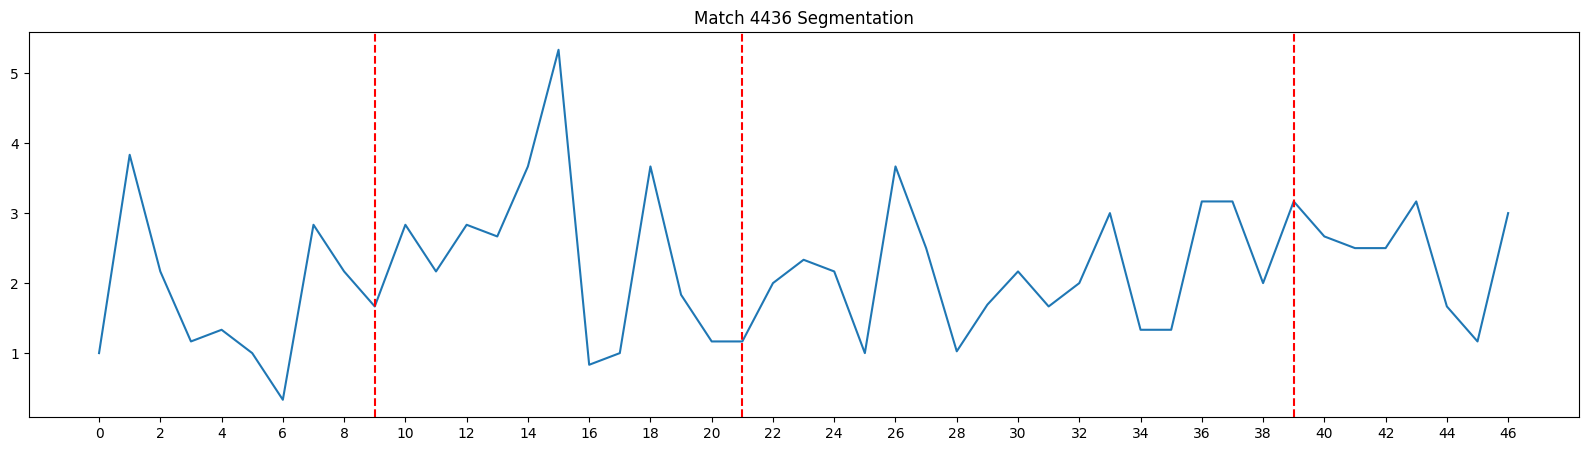

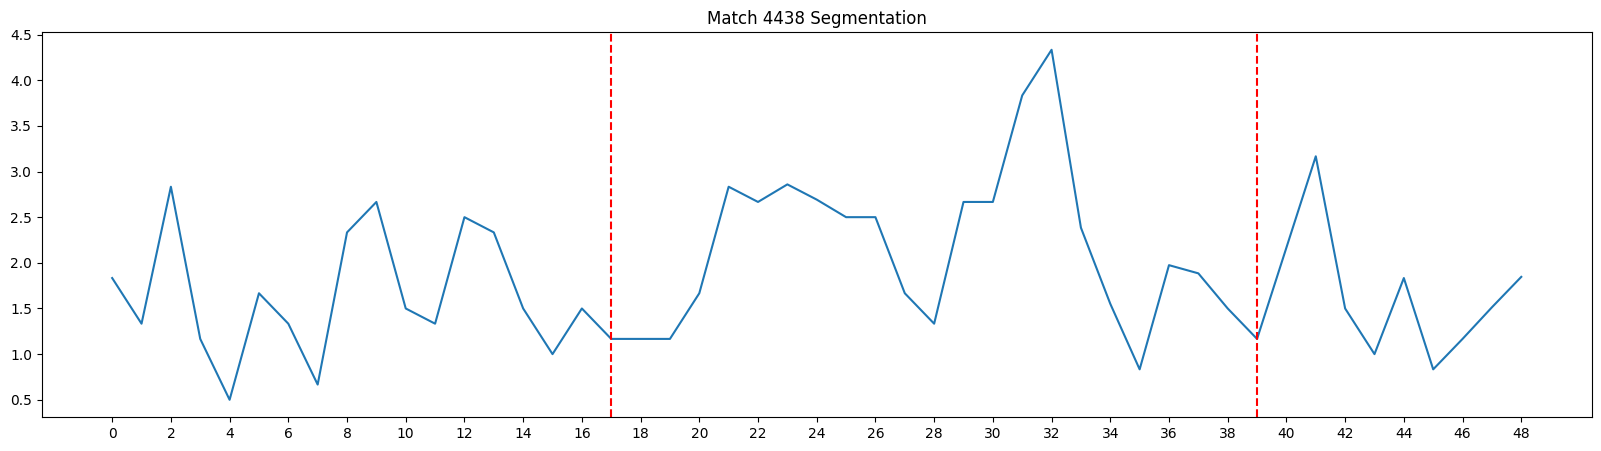

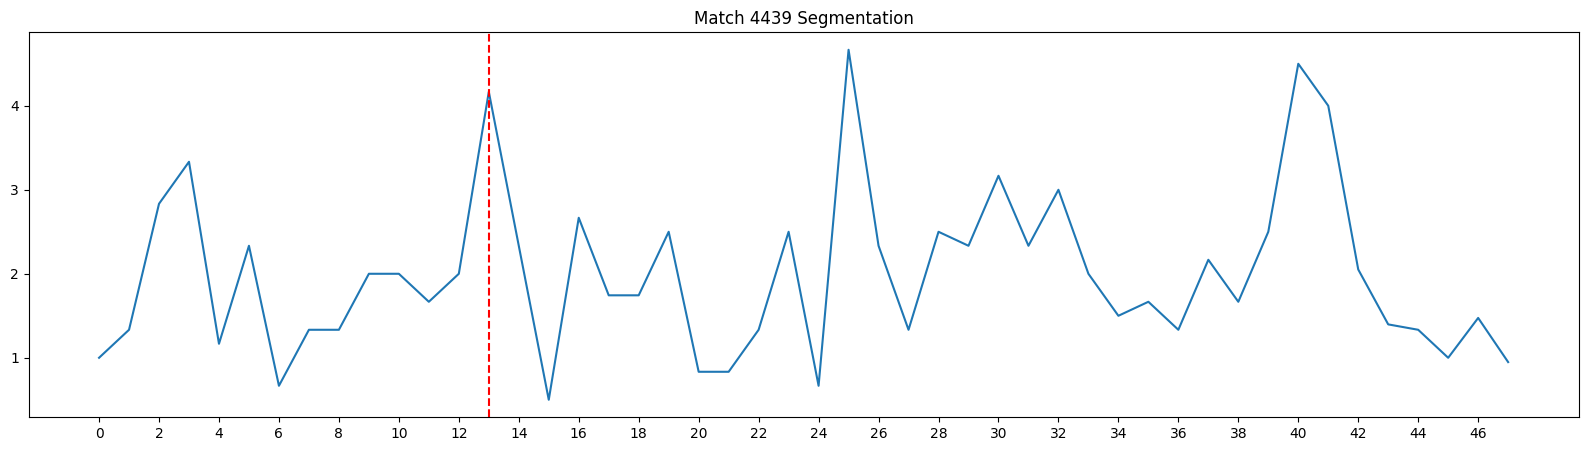

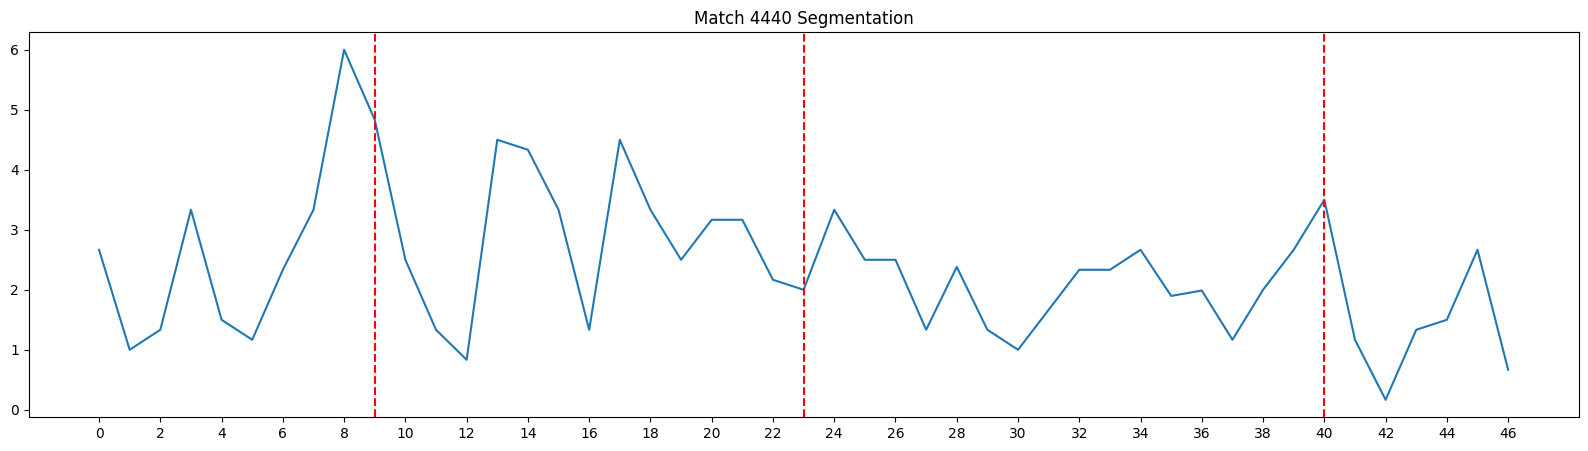

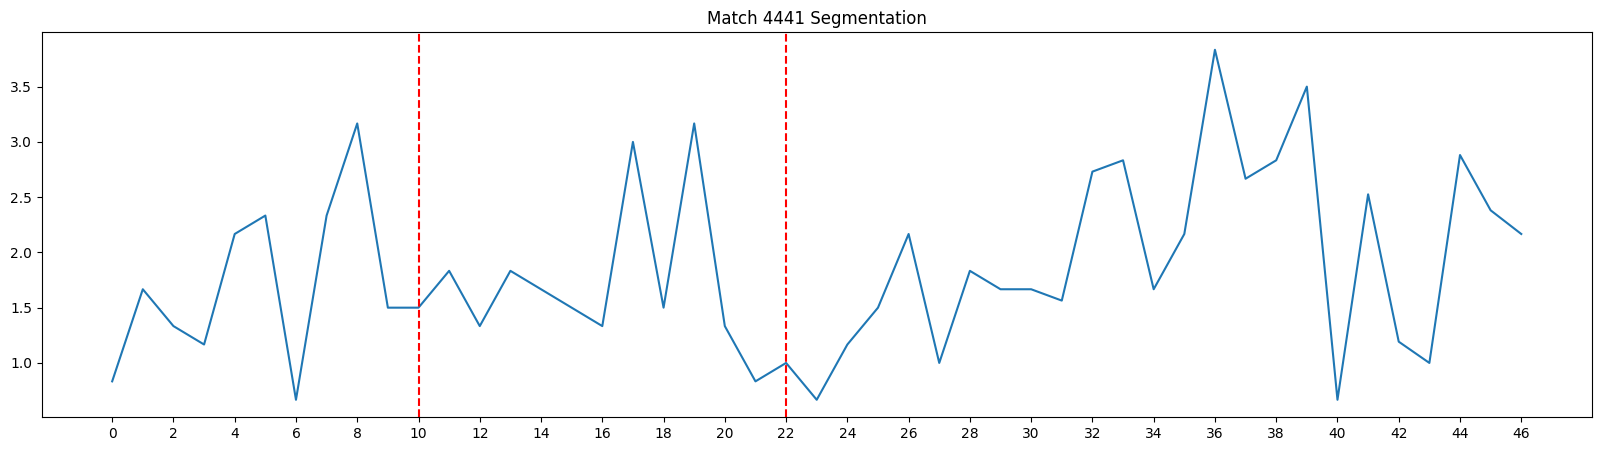

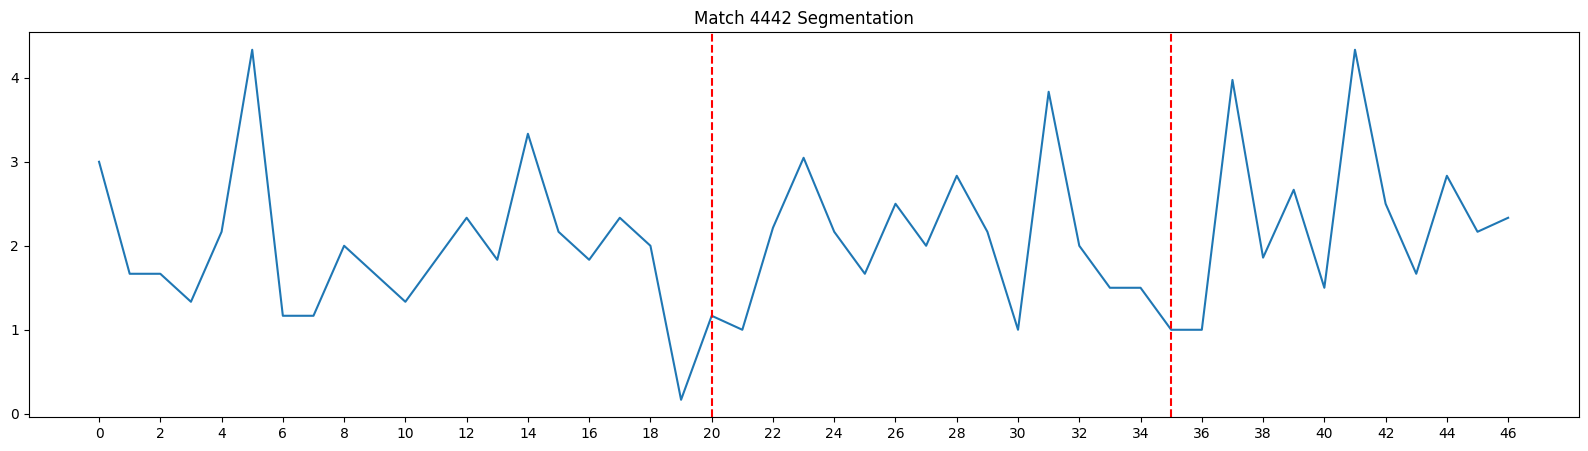

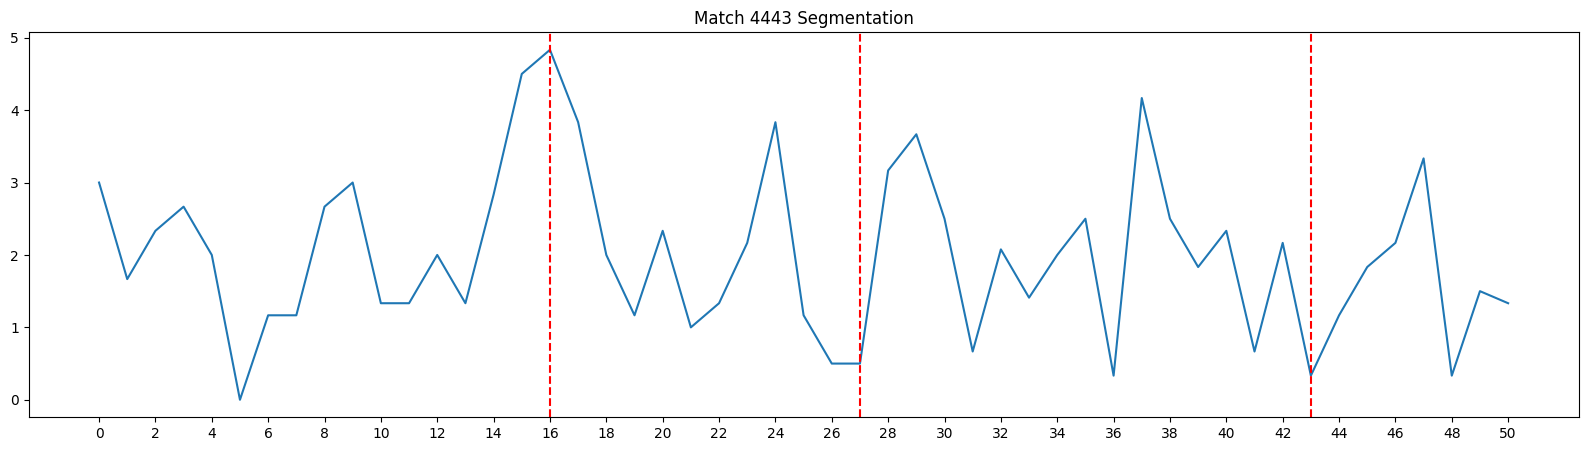

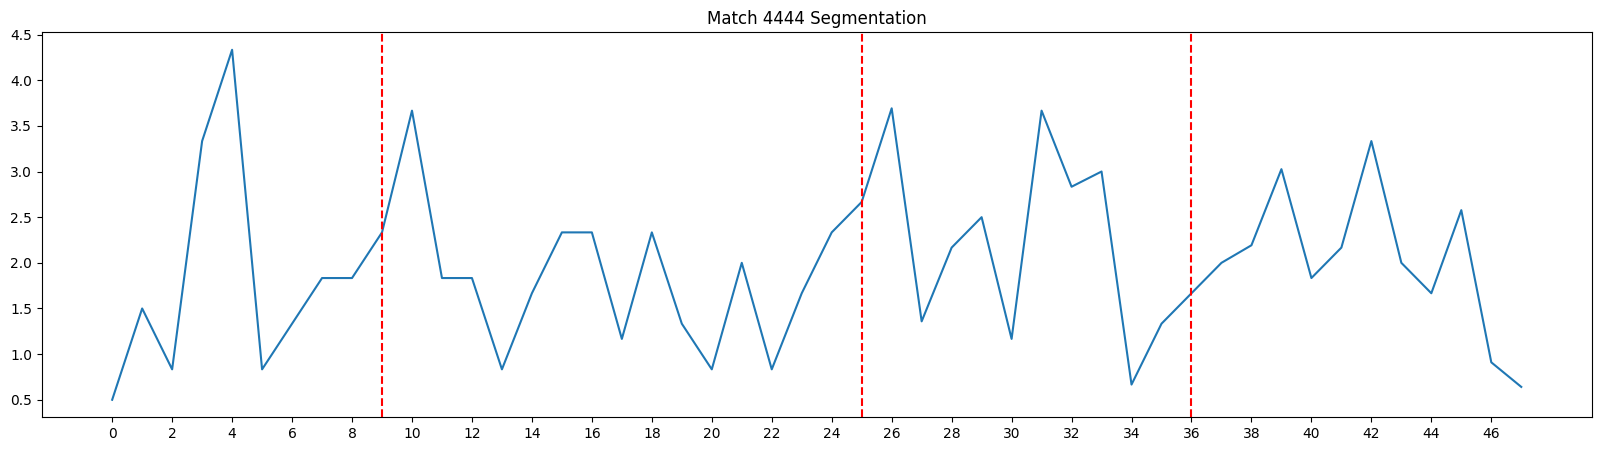

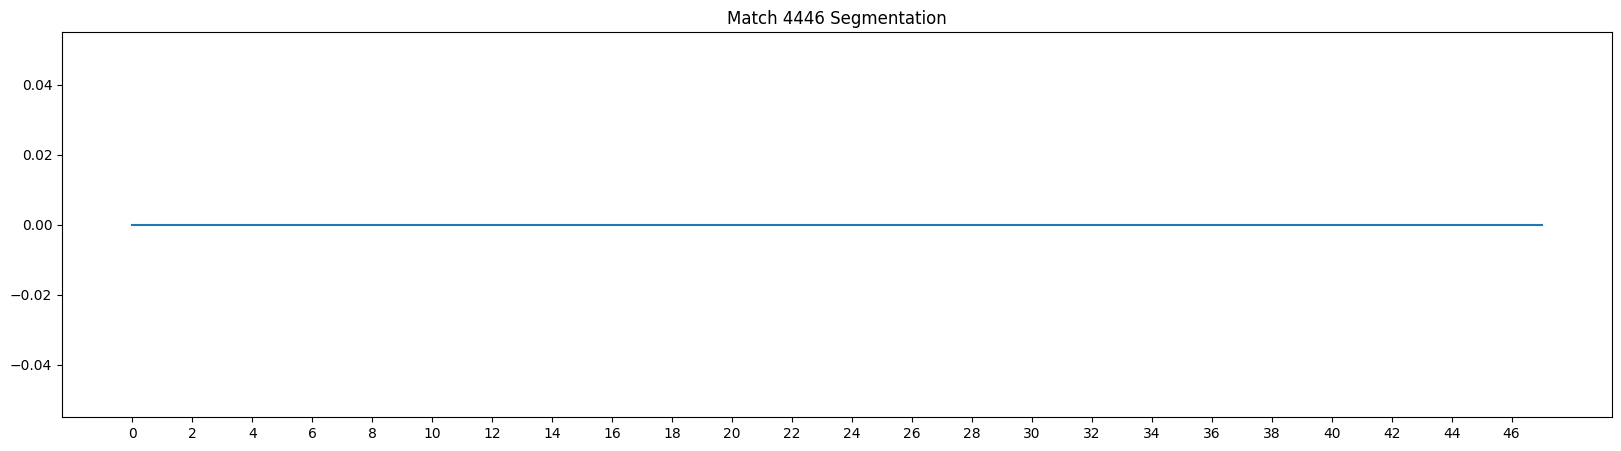

In [38]:
for match_id in drift_points:
    match_df = drift_stream_df[drift_stream_df['match_id'] == match_id['match_id']].reset_index(drop=True)
    plot_match_segmentation(match_id['match_id'], match_df['diff'], match_id['sum_drift_points'])